<a href="https://colab.research.google.com/github/amartyacodes/MedicalReportGenerator/blob/main/EncoderDecoderModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 freeze > requirements.txt

In [ ]:
pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pipreqs
pipreqs '/content'

SyntaxError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/FinalYearProject')
!wget "https://github.com/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/raw/main/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"
os.chdir('/content/')

--2022-06-01 07:41:48--  https://github.com/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/raw/main/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/main/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5 [following]
--2022-06-01 07:41:49--  https://raw.githubusercontent.com/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/main/chexnet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
image_folder = '/content/drive/MyDrive/FinalYearProject/Images'
df_path = '/content/drive/MyDrive/FinalYearProject/df_final.pkl'
chexnet_weights = '/content/drive/MyDrive/FinalYearProject/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

## Importing Necessary Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,clear lungs . no acute cardiopulmonary abnorma...,3296.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...
1,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,no acute cardiopulmonary abnormality .,1469.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>


In [ ]:
df['impression'].value_counts()


no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                                             383
no acute cardiopulmonary findings .                                                                                                                                                                                                                                                                                                                                172
no acute cardiopulmonary disease .                                                                                                                                                                                                                                                        

In [ ]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)


In [ ]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [ ]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,3296.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
58,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,2575.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
167,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,3996.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
449,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,1939.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
648,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/FinalYearProject/Images...,/content/drive/MyDrive/FinalYearProject/Images...,3959.xml,<CLS> clear lungs . no acute cardiopulmonary a...,<CLS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15


In [ ]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

In [ ]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4487, 8)

In [ ]:
train.impression.value_counts()


low lung volumes otherwise clear .                                                                                                                                                                                                                         18
hyperinflated lungs air trapping versus inspiratory                                                                                                                                                                                                        18
normal chest no evidence of tuberculosis                                                                                                                                                                                                                   18
no acute cardiopulmonary abnormality .                                                                                                                                                                                                        

In [ ]:
# os.mkdir('/content/drive/MyDrive/FinalYearProject/pickle_files')

FileExistsError: ignored

In [ ]:
folder_name = '/content/drive/MyDrive/FinalYearProject/pickle_files'
file_name = 'train.pkl'
train.to_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test.to_pickle(os.path.join(folder_name,file_name))

In [ ]:
folder_name = '/content/drive/MyDrive/FinalYearProject/pickle_files'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

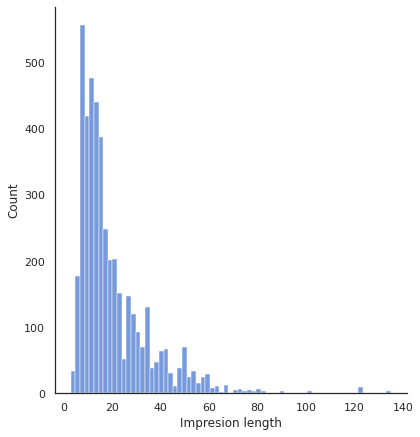


Value Counts for caption length top 5 values

Length|Counts
8     285
7     272
12    246
11    231
13    229
dtype: int64

The max and min value of "caption length" was found to be 135 and 3 respectively
The 80 percentile value of caption_len which is 29 will be taken as the maximum padded value for each impression


In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

## Building the Model

### Hyperparameters

In [ ]:

batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

### Input Data Pipeline

In [ ]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [ ]:
chexnet_weights = '/content/drive/MyDrive/FinalYearProject/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
def create_chexnet(chexnet_weights = chexnet_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return chexnet

In [ ]:

chexnet = create_chexnet()
chexnet.trainable = False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)

In [ ]:
del chexnet


## Simple Encoder Decoder Model

### Image Encoder Layer

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data)
    return op

In [ ]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d anindya2906/glove6b

In [ ]:
import shutil
shutil.copy('/content/glove6b.zip', '/content/drive/MyDrive/FinalYearProject')

'/content/drive/MyDrive/FinalYearProject/glove6b.zip'

In [ ]:
os.chdir('/content/drive/MyDrive/FinalYearProject')
!unzip "/content/drive/MyDrive/FinalYearProject/glove6b.zip"
os.chdir('/content')

Archive:  /content/drive/MyDrive/FinalYearProject/glove6b.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:

glove = {}
with open('/content/drive/MyDrive/FinalYearProject/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [ ]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))




img_encoder = Image_encoder() #contains chexnet model which is set trainable  =  False
# img2_encoder = Image_encoder() #opshape: (?,1024)
bk_feat1 = img_encoder(image1)
# bk_dense = Dense(dense_dim,
#                  activation = 'relu',
#                  name = 'bk_dense'
#                   )
# bk_feat1 = bk_dense(bk_feat1) #dense for the first image op: (?,dense_dim)

bk_feat2 = img_encoder(image2)
# bk_feat2 = bk_dense(bk_feat2) #dense for the 2nd image op: (?,dense_dim)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)
# bk_features_concat = BatchNormalization()(bk_features_concat) #applying batch norm
# bk_features_concat = Dropout(dropout_rate)(bk_features_concat) 
image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )

                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)



embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)






lstm_layer = LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

# lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [ ]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_encoder (Image_encoder)  (None, 1024)         7037504     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

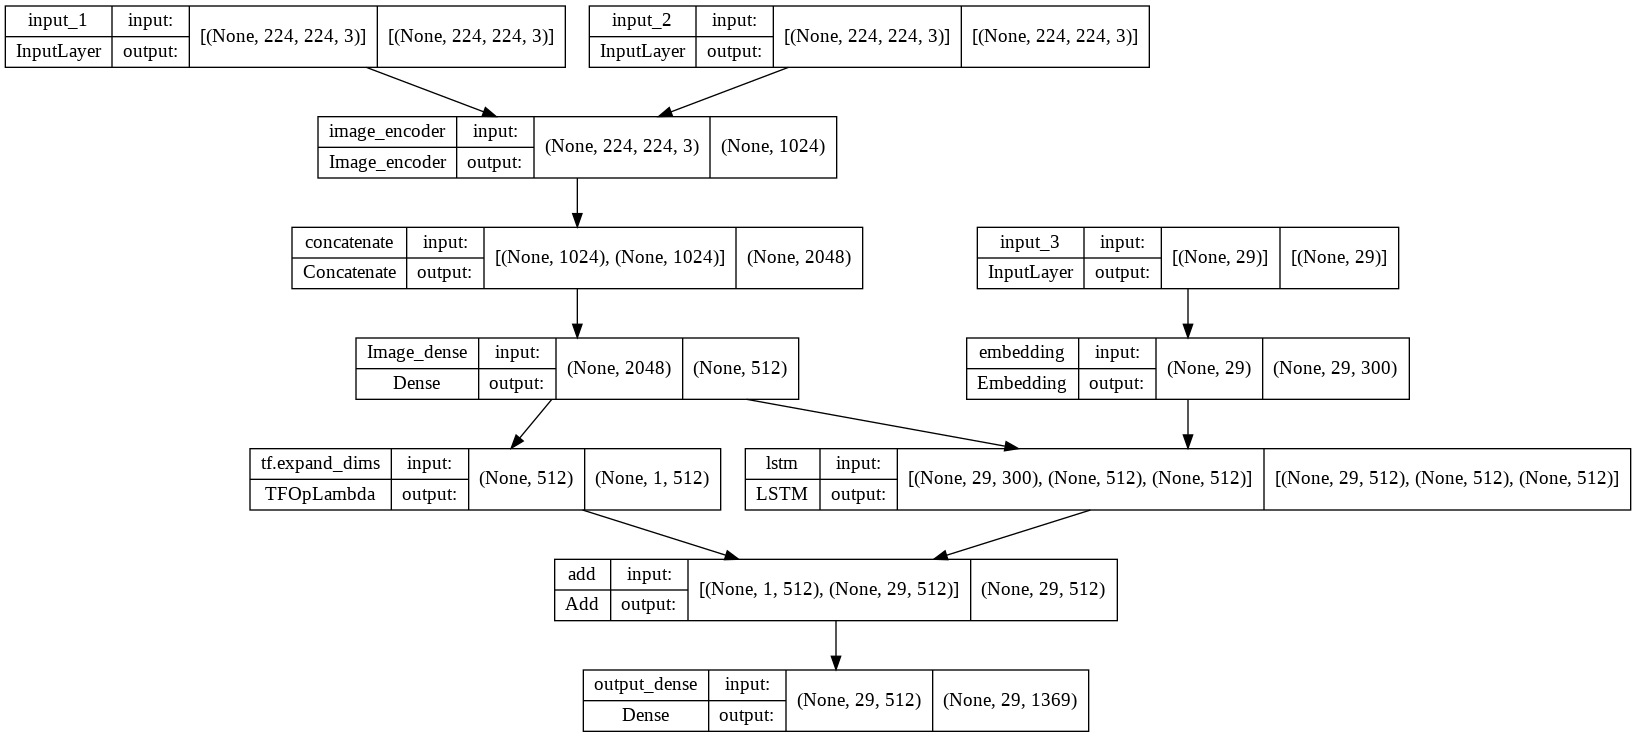

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Simple_Encoder_Decoder/'
tb_file = os.path.join('/content/drive/MyDrive/FinalYearProject',tb_filename)
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/content/drive/MyDrive/FinalYearProject',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [ ]:
# !rm -r '/content/drive/MyDrive/FinalYearProject/Simple_Encoder_Decoder/'


rm: cannot remove '/content/drive/MyDrive/FinalYearProject/Simple_Encoder_Decoder/': No such file or directory


In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 1.0338 - accuracy: 0.1485 
Epoch 1: val_loss improved from inf to 0.56449, saving model to /content/drive/MyDrive/FinalYearProject/Simple_Encoder_Decoder.h5
44/44 [==============================] - 986s 21s/step - loss: 1.0338 - accuracy: 0.1485 - val_loss: 0.5645 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.2833
Epoch 2: val_loss improved from 0.56449 to 0.33978, saving model to /content/drive/MyDrive/FinalYearProject/Simple_Encoder_Decoder.h5
44/44 [==============================] - 172s 4s/step - loss: 0.7366 - accuracy: 0.2833 - val_loss: 0.3398 - val_accuracy: 0.3830 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.3539
Epoch 3: val_loss improved from 0.33978 to 0.29165, saving model to /content/drive/MyDrive/FinalYearProject/Simple_Encoder_Decoder.h5
44/44 [=========================

In [ ]:
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/content/drive/MyDrive/FinalYearProject',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [ ]:
%load_ext tensorboard


In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/FinalYearProject/'


## Predictions

In [ ]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [ ]:

def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

In [ ]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  # image1 = model.get_layer('bk_dense')(image1) #op from dense layer
  # image2 = model.get_layer('bk_dense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  # concat = model.get_layer('batch_normalization')(concat)
  # image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array


In [ ]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(greedy_search_predict(image1,image2,model=model))

no acute cardiopulmonary abnormality .
CPU times: user 985 ms, sys: 20.4 ms, total: 1.01 s
Wall time: 1.18 s


In [ ]:
%%time
_ = mean_bleu(test,greedy_search_predict)

CPU times: user 3min 4s, sys: 2.13 s, total: 3min 6s
Wall time: 4min 13s


In [ ]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

In [ ]:
result


,bleu1,bleu2,bleu3,bleu4
greedy search,0.312363,0.309093,0.33605,0.36939


## Beam Search

In [ ]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255

  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)
  states = [image_dense, image_dense]
  return bk_feat,states

In [ ]:
def beam_search_predict(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  bk_feat,states = encoder_op(image1,image2)
  seq_score = [[cls_token,0,states]] #[[[3], 0]]
  finished_seq_score = []
  for i in range(max_pad): #traverse through all lengths
    all_candidates = [] #stores all the top k seq along with their scores
    new_seq_score = [] #stores the seq_score which does not have <end> in them
    for s in seq_score: #traverse for all top k sequences
      text_input = s[0][-1] #getting the last predicted output
      # print(s)
      states = s[2]
      caption = model.get_layer('embedding')(np.array([[text_input]])) #ip must be in shape (batch_size,seq length,dim)
      caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states)
      states = [state_h,state_c]
      add = model.get_layer('add')([bk_feat,caption])
      output = model.get_layer('output_dense')(add)[0][0] #(vocab_size,)
      top_words = tf.argsort(output,direction = 'DESCENDING')[:k] #get the top k words

      seq,score,_ = s
      for t in top_words.numpy():
        #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
        #here since its -(log), lower the score higher the prob
        candidates = [seq+[t],score-np.log(output[t].numpy()),states] #updating the score and seq
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
      #checks for  <end> in each seq obtained
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        # print('seq,score',seq,score)
        if seq[-1] == end_token: #if last word of the seq is <end>
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count #substracting the no. of finished sentences from beam length
      seq_score = new_seq_score

      if seq_score==[]: #if null array
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]

In [ ]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(beam_search_predict(image1,image2,top_k = 3))

no acute cardiopulmonary abnormality .
CPU times: user 5.16 s, sys: 111 ms, total: 5.27 s
Wall time: 7.7 s


In [ ]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(beam_search_predict(image1,image2,top_k = 5))

no acute cardiopulmonary abnormality .
CPU times: user 38.6 s, sys: 1.61 s, total: 40.3 s
Wall time: 40.5 s


In [ ]:
%%time
_ = mean_bleu(test,beam_search_predict)

CPU times: user 36min 30s, sys: 1min 38s, total: 38min 9s
Wall time: 35min 9s


In [ ]:
k = list(_)
index = 'beam search (top_k = 3)'
temp = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result = result.append(temp)
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.312363,0.309093,0.336050,0.369390
beam search (top_k = 3),0.310219,0.306974,0.333274,0.365895


## Inference

In [ ]:
# %%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['bleu_1_bm'] = np.zeros(test.shape[0]) #beam search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_bm'] = np.zeros(test.shape[0]) #beam search
for index,rows in test.iterrows():
  #greedy search
  predicted_text = greedy_search_predict(rows.image_1,rows.image_2,model1)
  test.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['impression'].split()]
  test.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

  #beam search
  predicted_text = beam_search_predict(rows.image_1,rows.image_2,top_k = 3,model = model1)
  test.loc[index,'prediction_bm'] = predicted_text
  test.loc[index,'bleu_1_bm'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search


no acute cardiopulmonary abnormality .                                              95.737123
cardiomegaly with central vascular congestion and interstitial edema .               1.420959
cardiomegaly and pulmonary venous hypertension .                                     1.420959
cardiomegaly with central pulmonary vascular congestion and interstitial edema .     1.243339
cardiomegaly and pulmonary vascular congestion and interstitial edema .              0.177620
Name: prediction_gs, dtype: float64

In [ ]:
test['prediction_bm'].value_counts()*100/test.shape[0] #beam search


no acute cardiopulmonary abnormality .                             97.690941
low lung volumes with bibasilar atelectasis .                       1.598579
cardiomegaly and pulmonary venous hypertension .                    0.355240
low lung volumes otherwise clear .                                  0.177620
stable cardiomegaly without acute cardiopulmonary abnormality .     0.177620
Name: prediction_bm, dtype: float64

## Predictions on Test Data

In [ ]:

def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  elif method in ['beam','b']:
    pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
  else:
    print("Enter 'b' or 'beam' for beam search and 'g' or 'greedy' for greedy search")
  
  return pred_caption

In [ ]:
def inference(image1,image2,true_caption,model=model1,top_k = [3],image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
  #beam search of top_k
  if top_k != None:
    for i in top_k:
      beam_caption = final_caption_pred(image1,image2,method='b',model=model,top_k = i)
      print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))

## Report Generation on Sample Image

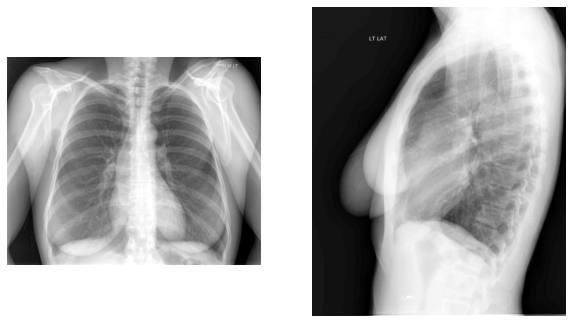


True caption: 'no acute cardiopulmonary abnormality identified .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality .'


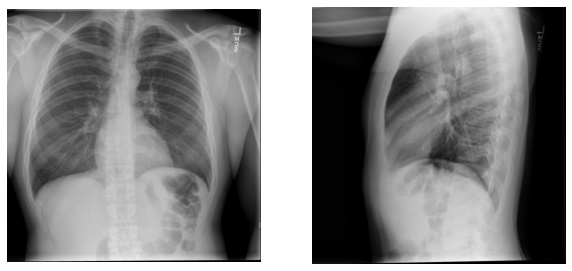


True caption: 'no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality .'


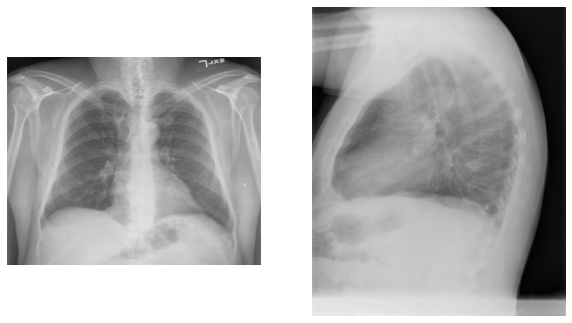


True caption: 'no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality .'


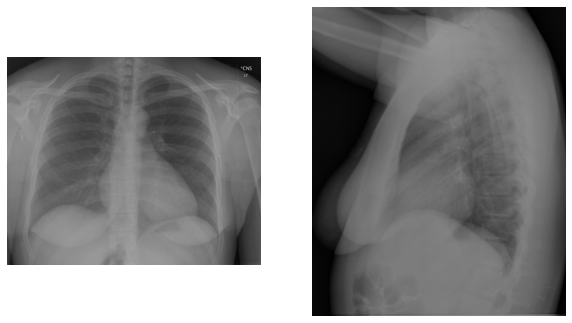


True caption: 'no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality .'


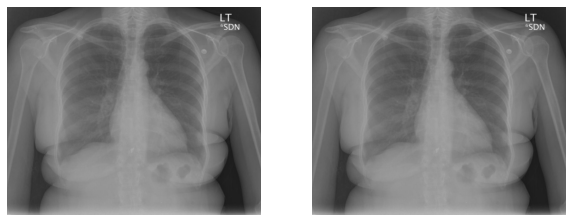


True caption: 'no acute cardiopulmonary abnormality identified .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality .'


In [ ]:

i = test[test['bleu_1_gs']>0.8].sample(5).index
for k in i:
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)

## Prediction of Captions on Test Data

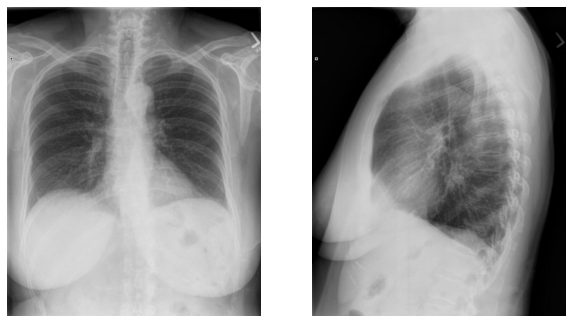


True caption: 'hyperexpanded but clear lungs .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'


In [ ]:

k = 160
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

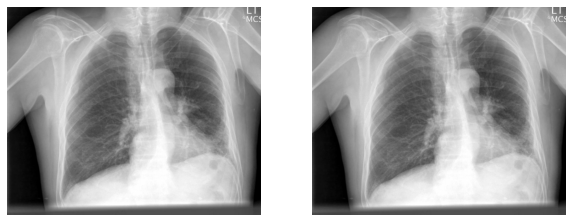


True caption: 'left basilar airspace disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'


In [ ]:
k = 290
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

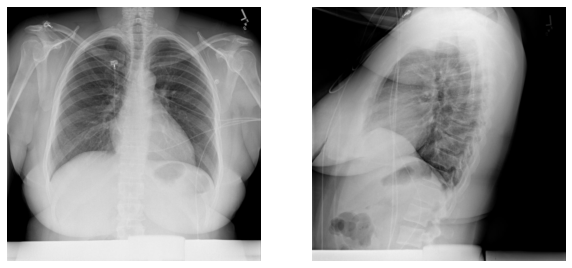


True caption: 'no acute cardiopulmonary disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality .'


In [ ]:
k = 25
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

## Conclusion 

In [ ]:
result


,bleu1,bleu2,bleu3,bleu4
greedy search,0.312363,0.309093,0.336050,0.369390
beam search (top_k = 3),0.310219,0.306974,0.333274,0.365895


In [ ]:
import shutil
shutil.copy('/content/model.png', '/content/drive/MyDrive/FinalYearProject')
shutil.copy('/content/model_1.png', '/content/drive/MyDrive/FinalYearProject')


'/content/drive/MyDrive/FinalYearProject/model_1.png'